# Fieldlines from `pfss`
Test importing fieldline coordinates from pfss

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors 
import sunpy.map
from scipy.io import readsav
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.coordinates.frames
import sunpy.sun.constants as constants

import synthesizAR
from synthesizAR.util import is_visible

from sav_converter import sav_to_hpc_map, sav_to_synoptic_map

%matplotlib inline

In [3]:
hpc0_map = sav_to_hpc_map('/Users/willbarnes/Downloads/0long166800.sav',pad=10,plot_settings = None )

In [53]:
hpc180_map = sav_to_hpc_map('/Users/willbarnes/Downloads/180long166800.sav',pad=10,)

In [59]:
carrington_map = sav_to_synoptic_map('/Users/willbarnes/Downloads/n001_166800.sav',L0=0*u.deg,)

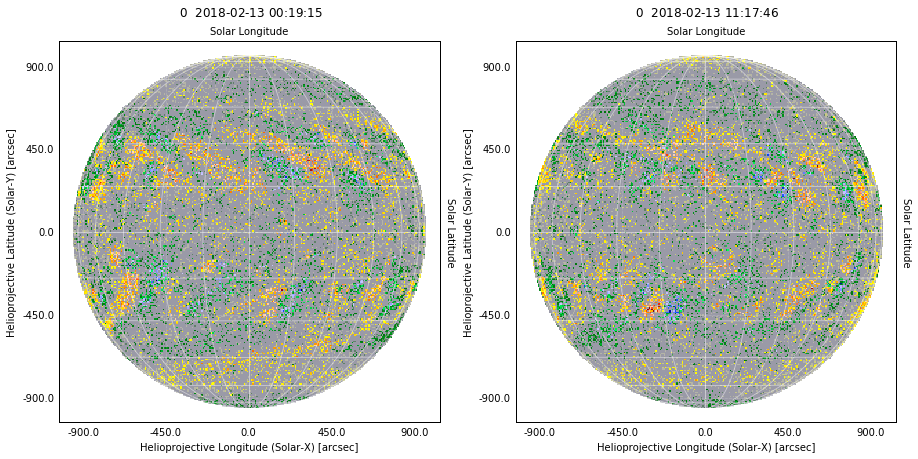

In [54]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121,projection=hpc0_map)
hpc0_map.plot(axes=ax,vmin=-1.5e3,vmax=1.5e3)
hpc0_map.draw_grid(color='w',axes=ax,)
ax = fig.add_subplot(122,projection=hpc180_map)
hpc180_map.plot(axes=ax,vmin=-1.5e3,vmax=1.5e3)
hpc180_map.draw_grid(color='w',axes=ax,)
plt.show()

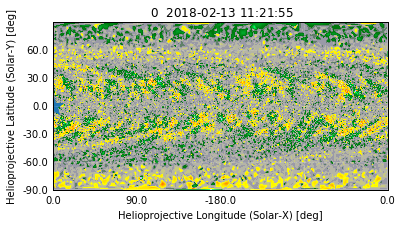

In [66]:
fig = plt.figure()
ax = fig.gca(projection=carrington_map)
carrington_map.plot(axes=ax,vmin=-1.5e3,vmax=1.5e3)
#carrington_map.draw_grid(color='w',axes=ax,)
ax.plot_coord(
    SkyCoord(Tx=90 * u.arcsec, Ty=0 * u.arcsec, frame=hpc0_map.coordinate_frame),
    color='C0', marker='*', markersize=20
)
plt.show()

Load in the fieldline coordinates from the `.sav` file. These are in Carrington Heliographic coordinates.

In [67]:
pfss_output = readsav('/Users/willbarnes/Downloads/pfssdata166800.sav')['pfss_data']

In [68]:
num_fieldlines = pfss_output['ptr'][0].shape[0]

In [69]:
fieldlines = []
for i in range(num_fieldlines):
    n_valid = pfss_output['nstep'][0][i]
    lon = (pfss_output['ptph'][0][i,:] * u.radian).to(u.deg)[:n_valid] #+ 90 * u.deg
    lat = 90 * u.deg - (pfss_output['ptth'][0][i,:] * u.radian).to(u.deg)[:n_valid]
    radius = ((pfss_output['ptr'][0][i,:]) * constants.radius.to(u.cm))[:n_valid]
    r_filter = np.where(np.logical_and(radius >=  0 * constants.radius,
                                       radius < 1000 * constants.radius,))
    fieldlines.append(SkyCoord(lon=lon[r_filter],
                               lat=lat[r_filter],
                               radius=radius[r_filter],
                               frame='heliographic_stonyhurst'))

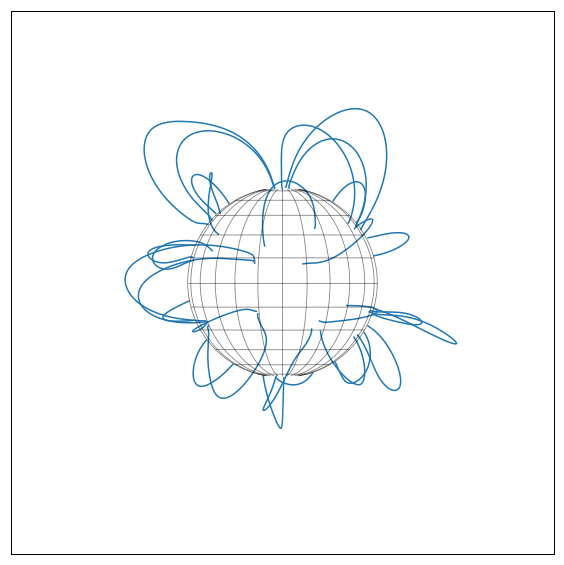

In [75]:
fig = plt.figure(figsize=(10,10),frameon=False)
# Make plot
dummy_map = sav_to_hpc_map('/Users/willbarnes/Downloads/0long166800.sav',
                           pad=10,plot_settings = None, L0=180 * u.deg, B0=0 * u.deg)
dummy_map = sunpy.map.Map(np.nan * dummy_map.data, dummy_map.meta)
# Plot magnetograme
ax = fig.add_subplot(111,projection=dummy_map)
dummy_map.plot(axes=ax,vmin=-1.5e3,vmax=1.5e3,title=False,annotate=False)
# Configure grid and axes
hgs_overlay = dummy_map.draw_grid(color='k',axes=ax,)
hgs_overlay[0].set_axislabel('')
hgs_overlay[1].set_axislabel('')
ax.coords[0].set_ticks_visible(False)
ax.coords[1].set_ticks_visible(False)
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)
# Pin view
ax.plot_coord(SkyCoord(-2500 * u.arcsec,-2500 * u.arcsec,frame=dummy_map.coordinate_frame),'w.')
ax.plot_coord(SkyCoord(2500 * u.arcsec,2500 * u.arcsec,frame=dummy_map.coordinate_frame),'w.')
# Plot fieldlines
for f in fieldlines:
    if (np.fabs(f.radius[-1] - f.radius[0])/constants.radius).decompose() < 0.5:
        color = 'C0'
    else:
        color = 'C3'
        continue
    hpc_coords = f.transform_to(dummy_map.coordinate_frame)
    i_visible = np.where(is_visible(hpc_coords, dummy_map.observer_coordinate))
    visible_coords = SkyCoord(Tx=hpc_coords.Tx[i_visible],
                              Ty=hpc_coords.Ty[i_visible],
                              distance=hpc_coords.distance[i_visible],
                              frame=dummy_map.coordinate_frame)
    ax.plot_coord(visible_coords,
                  ls='-',
                  alpha=1,
                  color=color)

Make a "spinning globe" animation to see the fieldlines from all sides.

In [52]:
fig = plt.figure(figsize=(10,10),frameon=False)
observed_phi = np.linspace(0,360,32) * u.deg
for i,phi_obs in enumerate(observed_phi):
    # Make plot
    dummy_map = sav_to_hpc_map('/Users/willbarnes/Downloads/0long166800.sav',
                               pad=10,plot_settings = None, L0=phi_obs, B0=0 * u.deg)
    dummy_map = sunpy.map.Map(np.nan * dummy_map.data, dummy_map.meta)
    # Plot magnetograme
    ax = fig.add_subplot(111,projection=dummy_map)
    dummy_map.plot(axes=ax,vmin=-1.5e3,vmax=1.5e3,title=False,annotate=False)
    # Configure grid and axes
    hgs_overlay = dummy_map.draw_grid(color='k',axes=ax,)
    hgs_overlay[0].set_axislabel('')
    hgs_overlay[1].set_axislabel('')
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    # Pin view
    ax.plot_coord(SkyCoord(-2500 * u.arcsec,-2500 * u.arcsec,frame=dummy_map.coordinate_frame),'w.')
    ax.plot_coord(SkyCoord(2500 * u.arcsec,2500 * u.arcsec,frame=dummy_map.coordinate_frame),'w.')
    # Plot fieldlines
    for f in fieldlines:
        if (np.fabs(f.radius[-1] - f.radius[0])/constants.radius).decompose() < 0.5:
            color = 'C0'
        else:
            color = 'C3'
        hpc_coords = f.transform_to(dummy_map.coordinate_frame)
        i_visible = np.where(is_visible(hpc_coords, dummy_map.observer_coordinate))
        visible_coords = SkyCoord(Tx=hpc_coords.Tx[i_visible],
                                  Ty=hpc_coords.Ty[i_visible],
                                  distance=hpc_coords.distance[i_visible],
                                  frame=dummy_map.coordinate_frame)
        ax.plot_coord(visible_coords,
                      ls='-',
                      alpha=1,
                      color=color)
    fig.savefig(f'/Users/willbarnes/Desktop/fieldline_figs/frame_phi{i:06d}.png',format='png',dpi=300)
    fig.clf()

In [ ]:
fieldlines[11]

In [ ]:
(fieldlines[1].radius.to(u.m)/constants.radius).value

In [ ]:
(pfss_output['ptph'][0][4,:] * u.radian).to(u.deg).value

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=carrington_map)
carrington_map.plot(axes=ax,vmin=-1.5e3,vmax=1.5e3)
carrington_map.draw_grid(color='w',axes=ax,)
for f in fieldlines:
    ax.plot_coord(f.transform_to(carrington_map.coordinate_frame),
                  '-k'
                 )
plt.show()

In [ ]:
plt.hist(np.hstack([f.lat.value for f in fieldlines]),histtype='step',lw=2,bins='scott');